# Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

from pathlib import Path

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

import tensorflow as tf
#import tensorflow_addons as tfa


from utils.train import Trainer
from utils.distiller import Distiller
from utils.tools import *
from utils.preprocess import *
from utils.visualize import *
from utils.training_tools import *

IMN_STD = [0.229, 0.224, 0.225]
IMN_MEAN = [0.485, 0.456, 0.406]

In [3]:
config = read_yaml('utils/config.yaml')

config['ID'] = 0
config['SEED'] = 42
config['METHOD'] = 'KD'
config['UNISTYLE'] = False
config['WHITEN_LAYERS'] = []
config['DATA_PATH'] = '../AgriSeg_Dataset/'
model_root= Path('bin/Benchmark/')
label = 'Ours'
model_path = model_root.joinpath(label)
weights = [model_path.joinpath(f) for f in os.listdir(model_path) if f.endswith('.h5')]
targets = ['pear', 'zucchini', 'vineyard_real_new', 'lavender_real']

In [4]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", physical_devices)

#select the working GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

devices = []
for g in [0]:
    tf.config.experimental.set_memory_growth(gpus[g], True)
    devices.append(f'GPU:{g}')
#strategy = tf.distribute.MirroredStrategy(devices=devices)

Num GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Test Function

In [6]:
from utils.mobilenet_v3 import MobileNetV3Large
from utils.models import build_model_multi, build_model_binary
from pathlib import Path

In [7]:
def get_single_model(config, weights=None, feats=True, whiten=False, model_dir=None):
        
        whiten_layers = config['WHITEN_LAYERS'] if whiten \
                        and config['UNISTYLE'] \
                        and config['METHOD'] in ['KD'] else []
            
        backbone = MobileNetV3Large(
            input_shape=(config['IMG_SIZE'], config['IMG_SIZE'], 3),
            alpha=1.0,
            minimalistic=False,
            include_top=False,
            weights='imagenet',
            input_tensor=None,
            classes=config['N_CLASSES'],
            pooling='avg',
            dropout_rate=False,
            mode=config['METHOD'], p=config['PADAIN']['P'],
            eps=float(config['PADAIN']['EPS']),
            whiten_layers=whiten_layers,
            backend=tf.keras.backend, layers=tf.keras.layers, models=tf.keras.models, 
            utils=tf.keras.utils)
        
        pre_trained_model = backbone

        # binary segmentation model
        model = build_model_binary(pre_trained_model, False, config['N_CLASSES'], 
                                    sigmoid=config['LOSS']=='iou', mode=config['METHOD'],
                                    p=config['PADAIN']['P'], eps=float(config['PADAIN']['EPS']),
                                    return_feats=feats)
        
        if weights:
            model.load_weights(model_dir.joinpath(weights))
        model.trainable = True
        
        return model
 

def get_teacher(config):
    domains = [w for w in config['SOURCE'] if w != config['TARGET']]
    weights = [f'teachers/teacher_aug_{w}.h5' for w in domains]
    print(f'Loaded Teachers: {domains}')
    
    models = [get_single_model(config, w, feats=False, model_dir=Path('bin/')) for w in weights]
    
    model_input = tf.keras.Input(shape=(config['IMG_SIZE'], config['IMG_SIZE'], 3))
    model_outputs = [model(model_input) for model in models]
    ensemble_output = tf.keras.layers.Average()(model_outputs)
    teacher = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
    return teacher

In [8]:
def test_fn(config,
            model_path,
            targets,
            strategy=None, 
            ensemble=False):
    
    res = []
    for model_name in model_path:
        print(str(model_name))
        for t in targets:
            tf.keras.backend.clear_session()
            config['TARGET'] = t
            
            if config['METHOD'] != 'KD':
                trainer = Trainer(config, logger=None, strategy=strategy, test=True)
            else:
                trainer = Distiller(config, logger=None, strategy=strategy, test=True)

            # trainer.model.summary()
            if ensemble:
                trainer.moddel = get_teacher(config)
            else:
                trainer.model.load_weights(str(model_name))
            
            loss, metric = trainer.evaluate(trainer.ds_test, 'test')
            print(metric.numpy())
            print('')
            res.append(metric.numpy())
    return res

In [9]:
def visualize_fn(config,
                 model_path,
                 targets,
                 strategy=None,
                 n=1,
                 conf=0.0,
                 soft=False,
                 save=False):
    ts = {}
    plt.rcParams['figure.figsize'] = [4, 4]
    
    for model_name in model_path:
        print(str(model_name))
#         for t in targets:
#             if t in str(model_name):
#                 config['TARGET'] = t
        config['TARGET'] = targets[0]
        tf.keras.backend.clear_session()
        trainer = Trainer(config, logger=None, strategy=strategy, test=True)
        trainer.model.load_weights(str(model_name))
        c = n
        for image, y in trainer.ds_test:
            i = tf.cast((image[0] * IMN_STD + IMN_MEAN) * 255.0, tf.uint8)
            plt.imshow(i, alpha=1.0) 
            plt.axis('off')
            if save:
                plt.savefig(f'./demo/Input_{config["TARGET"]}_{c}.pdf',bbox_inches='tight', pad_inches=0)  
            plt.show()
            plt.imshow(y[0], alpha=1.0) 
            plt.axis('off')
            if save:
                plt.savefig(f'./demo/GT_{config["TARGET"]}_{c}.pdf',bbox_inches='tight', pad_inches=0)   
            plt.show()   
            out = trainer.model.predict(image[:1], verbose=0)[0][0]
            out = tf.math.sigmoid(out)

            if conf:
                if soft:
                    plt.imshow(out*tf.cast(out>conf, tf.float32), alpha=1)
                else:
                    plt.imshow(out>conf, alpha=1)
            else:
                plt.imshow(out, alpha=1.)
            plt.axis('off')

            if save:
                plt.savefig(f'./demo/{label}_{config["TARGET"]}_{c}.pdf',bbox_inches='tight', pad_inches=0)
            
            plt.show()

            c -= 1
            if c < 0:
                break

In [10]:
for target in targets:
    print(f'{target}\n')
    res = test_fn(config,
                  weights,
                  [target],
                  strategy=None,
                  ensemble=True)
    print(f'{target}: {np.mean(res)}\n')

pear

bin/Benchmark/Ours/tot_kd_pero_KD_4.h5
{'ADAM': {'LR': '3e-4'},
 'ADAMW': {'DECAY': 1, 'LR': '5e-3', 'LR_END': '5e-6', 'WD': '1e-5'},
 'AUX_LOSS': False,
 'BATCH_SIZE': 64,
 'CITYSCAPES': False,
 'CL': {'TEMP': 0.5, 'WEIGHT': 0.0},
 'DATA_PATH': '../AgriSeg_Dataset/',
 'DG': True,
 'GPU': [0],
 'HP_SEARCH': False,
 'HP_SEARCH_DIR': 'trials',
 'HP_SEARCH_NAME': 'kd_aug_rome',
 'ID': 0,
 'IMG_SIZE': 224,
 'KD': {'ALPHA': 0.0001, 'T': 2},
 'LOG_PATH': 'logs/',
 'LOSS': 'bce',
 'METHOD': 'KD',
 'MODEL_PATH': 'bin/',
 'NAME': 'ISW',
 'N_CLASSES': 1,
 'N_EPOCHS': 50,
 'N_TRIALS': 12,
 'OPTIMIZER': 'adamw',
 'PADAIN': {'EPS': '1e-5', 'P': 0.001},
 'RND_CROP': 0.5,
 'RND_FLIP': 0.5,
 'RND_GREY': 0.1,
 'RND_JITTER': 1.0,
 'RND_JITTER_RNG': 0.4,
 'SAVE_BEST': True,
 'SEED': 42,
 'SGD': {'DECAY': 0.1, 'LR': '1e-2', 'MOMENTUM': 0.8, 'NESTEROV': False},
 'SOURCE': ['tree_2', 'chard', 'lettuce', 'vineyard'],
 'SPLIT_SIZE': 0.1,
 'STYLE_AUG': True,
 'SUBSAMPLE': True,
 'TARGET': 'pear',
 'UNIST

In [11]:
raise StopExecution

bin/Benchmark/Ours/tot_kd_pero_KD_4.h5
Loaded data: Train 0, Val 0, Test 4800


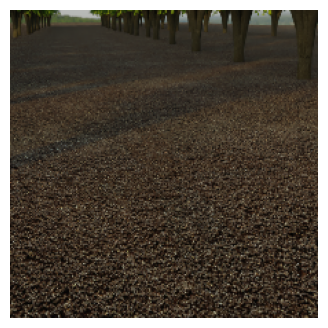

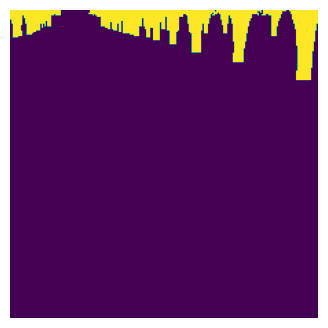

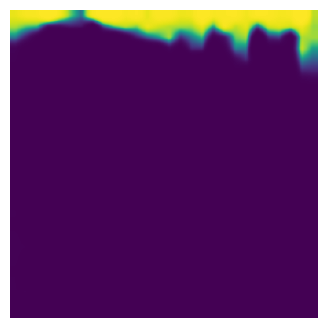

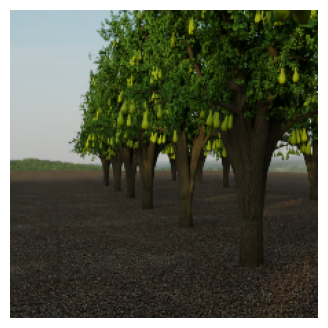

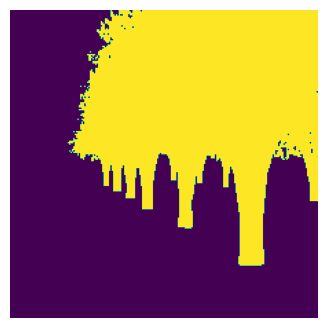

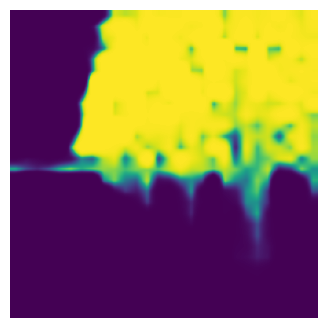

bin/Benchmark/Ours/tot_kd_pero_KD_3.h5
Loaded data: Train 0, Val 0, Test 4800


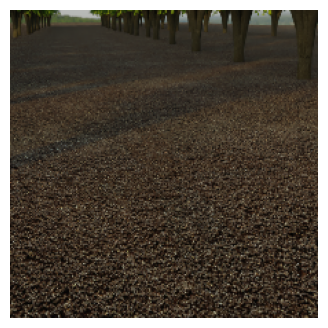

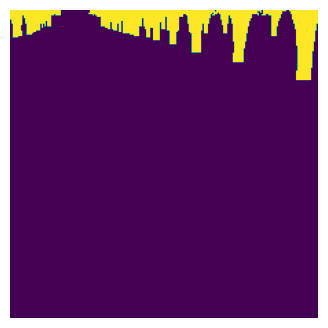

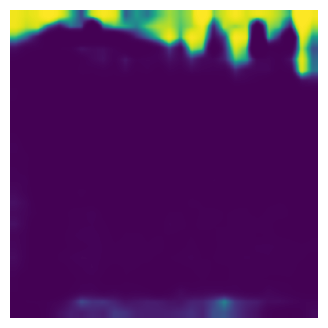

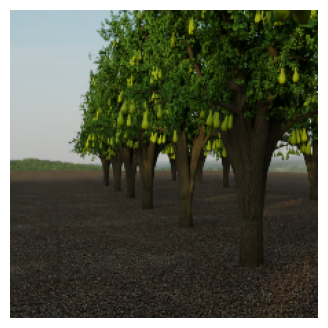

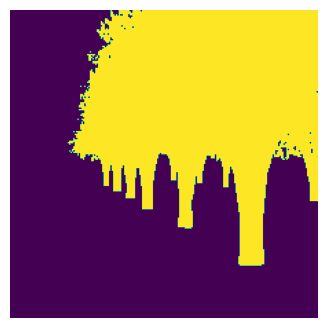

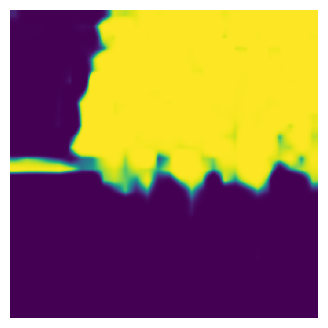

bin/Benchmark/Ours/tot_kd_pero_KD_2.h5
Loaded data: Train 0, Val 0, Test 4800


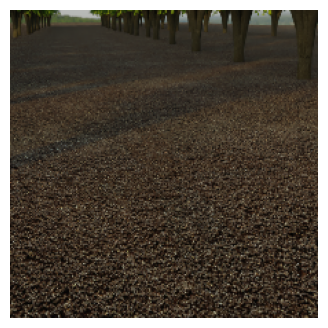

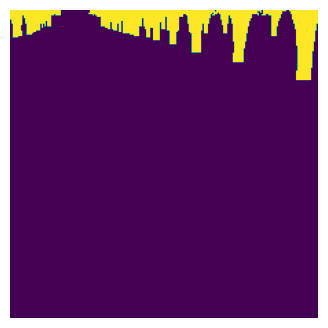

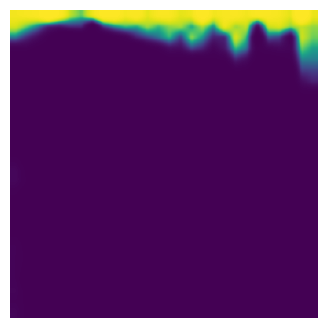

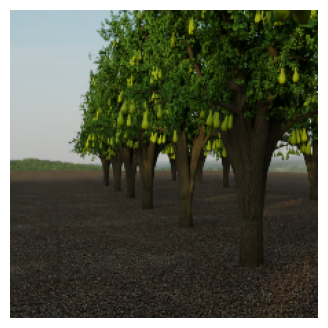

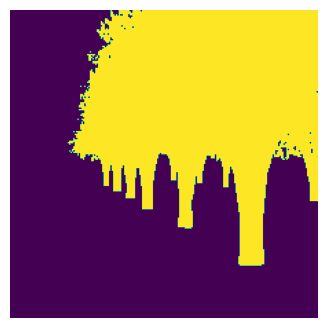

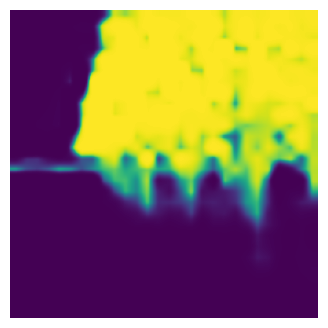

bin/Benchmark/Ours/tot_kd_pero_KD_5.h5
Loaded data: Train 0, Val 0, Test 4800


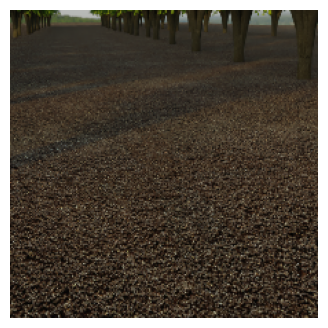

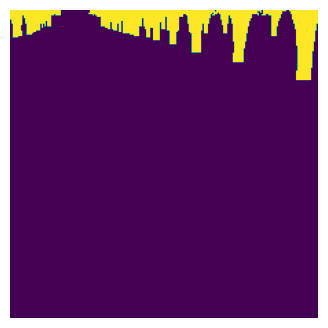

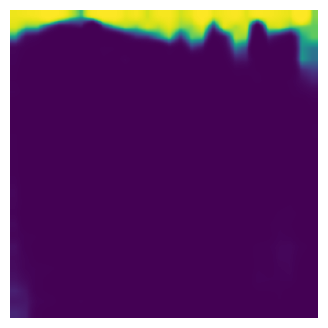

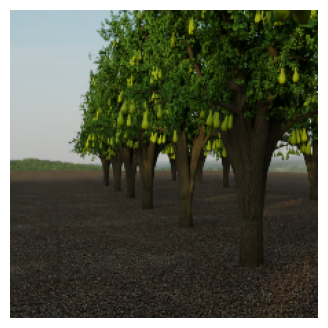

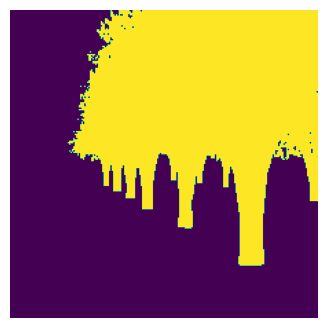

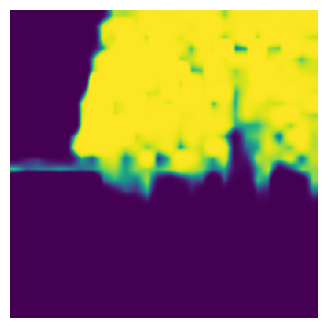

bin/Benchmark/Ours/tot_kd_pero_KD_1.h5
Loaded data: Train 0, Val 0, Test 4800


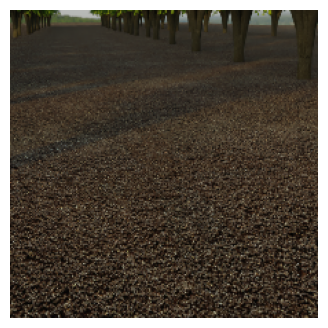

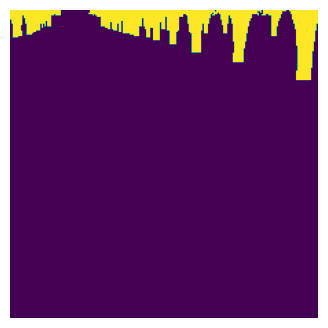

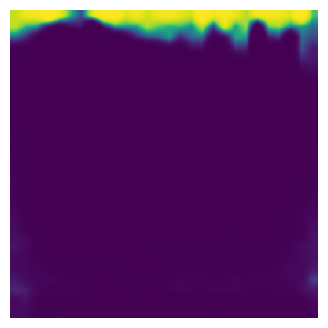

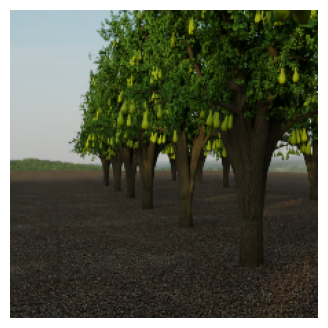

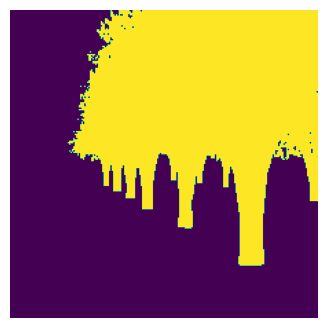

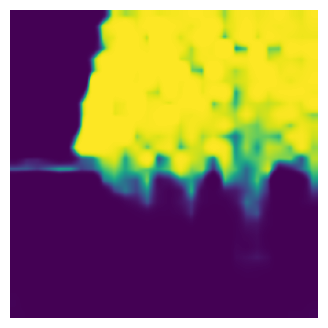

In [12]:
ls = visualize_fn(config,
             weights,
             targets,
             strategy=None,
             conf=0.0,
             soft=False,
             save=True)

# Development

In [13]:
config = read_yaml('utils/config.yaml')

config['NAME'] = 'test'
config['ID'] = 0
config['BATCH_SIZE'] = 64

config['TARGET'] = 'pero'
config['METHOD'] = 'ISW'
config['WHITEN_LAYERS'] = [0,1,2]

model_name = 'bin/Benchmark/test_isw_bieta_ISW_0.h5'

In [14]:
IMN_STD = [0.229, 0.224, 0.225]
IMN_MEAN = [0.485, 0.456, 0.406]

def predict_some_samples(trainer, n=1, conf=0.0, save=False):
    for image, _ in trainer.ds_test:
        
        out = trainer.model.predict(image[:1], verbose=0)[0][0]
        print(out.shape)
        print(np.min(out), np.max(out))
        out = tf.math.sigmoid(out)
        if conf:
            plt.imshow(out>conf, alpha=0.8)
        else:
            plt.imshow(out, alpha=0.8)
        i = tf.cast((image[0] * IMN_STD + IMN_MEAN) * 255.0, tf.uint8)
        plt.imshow(i, alpha=0.6) 
        
        if save:
            plt.savefig(f'./demo/{n-1}.png')
        
        plt.show()
    
        n -= 1
        if n < 0:
            break

In [15]:
trainer = Trainer(config, logger=None, strategy=None, test=True)
trainer.model.load_weights(model_name)
predict_some_samples(trainer, n=5, conf=0., save=False)
trainer.evaluate(trainer.ds_test, 'test')

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/pero'

# TFLIite Conversion

In [ ]:
raise

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(trainer.model)
converter.experimental_new_converter = True
tflite_model = converter.convert()

name_model_tflite = 'lavanda.tflite'
tflite_model_file = Path(config['MODEL_PATH']).joinpath(name_model_tflite)                          
tflite_model_file.write_bytes(tflite_model)

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="bin/lavanda.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
output_details[0]

# XDED

In [ ]:
import tensorflow as tf

In [ ]:
class pixelwise_XDEDLoss(tf.keras.losses.Loss):
    def __init__(self, temp_factor=2.0):
        super(pixelwise_XDEDLoss, self).__init__()
        self.temp_factor = temp_factor
        self.kl_div = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.SUM)
        self.CLASS_NUM = 1

    def xded_loss(self, input, target):
        
        loss = self.kl_div(tf.nn.softmax(input/self.temp_factor, axis=-1),
                           tf.nn.softmax(target/self.temp_factor, axis=-1)) * (self.temp_factor**2)/input.shape[0]
        return loss

    def call(self, main_out, gts):
        # main_out.shape : [batch, 1, 768, 768]
        # gts.shape : [batch, 768, 768]

        batch_size = main_out.shape[0]
        print(batch_size)
        flat_gts = tf.reshape(gts,[-1,1]) # [batch*768*768]
        flat_out = tf.reshape(main_out,(-1, self.CLASS_NUM))
        not_flat_out = not flat_out

        flat_targets = tf.reshape(main_out,(-1, self.CLASS_NUM))
        # [batch*768*768, 1]

        cur_gt_idx = flat_gts == 1 # [False, True, ...]
        not_cur_gt_idx = flat_gts == 0 # [True, False, ...]
        print(cur_gt_idx.shape)
        
        x = tf.boolean_mask(flat_out,cur_gt_idx)
        not_x = tf.boolean_mask(flat_out,not_cur_gt_idx)
        
        flat_targets = tf.reduce_mean(x) * tf.cast(cur_gt_idx,tf.float32)
        not_flat_targets = tf.reduce_mean(not_x) * tf.cast(not_cur_gt_idx,tf.float32)
        print(flat_out.shape, not_flat_out.shape)
        print(flat_targets.shape, not_flat_targets.shape)
        
        
        
        return self.xded_loss(flat_out, flat_targets)

In [ ]:
ys = tf.random.uniform((64,224,224,1))*10
y  = tf.cast(tf.random.uniform((64,224,224,1),maxval=2,dtype=tf.int32), tf.float32)

In [ ]:
print(np.min(ys), np.max(ys))
print(np.min(y), np.max(y))

In [ ]:
@tf.function
def loss(y_pred,y):
    l = pixelwise_XDEDLoss()
    return l(y_pred,y)

In [ ]:
loss(ys,y)

In [ ]:
import torch
from torch.nn import functional as F

In [ ]:
class pixelwise_XDEDLoss(torch.nn.Module):
    def __init__(self, temp_factor=2.0):
        super(pixelwise_XDEDLoss, self).__init__()
        self.temp_factor = temp_factor
        self.kl_div = torch.nn.KLDivLoss(reduction="sum")
        self.CLASS_NUM = 1

    def xded_loss(self, input, target):
        log_p = torch.log_softmax(input/self.temp_factor, dim=0)
        q = torch.softmax(target/self.temp_factor, dim=0)
        loss = self.kl_div(log_p, q)*(self.temp_factor**2)/input.size(0)
        return loss

    def forward(self, main_out, gts):
        # main_out.shape : [batch, 19, 768, 768]
        # gts.shape : [batch, 768, 768]

        batch_size = main_out.shape[0]

        flat_gts = gts.reshape(-1) # [batch*768*768]
        flat_out = main_out.reshape(-1, self.CLASS_NUM)

        flat_targets = main_out.clone().detach().reshape(-1, self.CLASS_NUM)
        # [batch*768*768, 19]

        flat_gt_set = flat_gts.unique().tolist()
        ensemble_dict= {}

        for f_gt in flat_gt_set:
            if f_gt == 255:
                continue
            cur_gt_idx = flat_gts == f_gt # [False, True, ...]
            flat_targets[cur_gt_idx, :] = flat_out[cur_gt_idx].mean(0).detach()

        return self.xded_loss(flat_out, flat_targets)

In [ ]:
ys = torch.rand((64,1,224,224))
y = torch.randint(size=(64,224,224),high=2)

In [ ]:
l = pixelwise_XDEDLoss()

In [ ]:
l(ys,y)